<img src="../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# Non-Clifford CNOT-Dihedral Randomized Benchmarking
# of a CS gate

- Last Updated: ???
- Requires: qiskit-terra ???, qiskit-ignis ???, qiskit-aer ???

## Introduction

**Non-Clifford CNOT-Dihedral Randomized Benhcmaking** is a variant of the Randomized Benchmarking (RB) method that is used for benchmarking certain non-Clifford gates via randomization, taken from the so-called *CNOT-dihedral group* which is generated by CNOTs and a single qubit dihedral group $\langle T, X \rangle$.
The method is based on the paper "Scalable randomized benchmarking of non-Clifford gates"(https://arxiv.org/abs/1510.02720).

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module in order to perform interleaved RB.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error
from qiskit.quantum_info.operators import Operator

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

## Select the Parameters of the non-Clifford CNOT-Dihedral RB Run

First, we need to choose the regular RB parameters:

- **nseeds:** The number of seeds. For each seed there you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of CNOT-dihedral lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later)
- **align_cliffs:** If true adds a barrier across all qubits in rb_pattern after each set of elements

As well as another parameter for non-Clifford CNOT-Dihedral RB:

- **group_gates = 'CNOT-Dihedral'** 

In this example we have 3 qubits Q0,Q1,Q2. We are running 2Q RB (on qubits Q0,Q2) and 1Q RB (on qubit Q1) simultaneously, where there are three times as many 1Q gates.

In [2]:
#Number of qubits
nQ = 3
#There are 3 qubits: Q0,Q1,Q2.
#Number of seeds (random sequences)
nseeds = 5
#Number of elements in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0,2],[1]]
#Do three times as many 1Q elements
length_multiplier = [1,3]
# Non-Clifford CNOT-Dihedral RB
group_gates = 'CNOT-Dihedral'

## Generate non-Clifford CNOT-Dihedral RB sequences

We generate RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the non-Clifford CNOT-Dihedral RB sequences rb_cnotdihedral_Z_circs and rb_cnotdihedral_X_circs, which are a list of lists of quantum circuits, we run the function **rb.randomized_benchmarking_seq**.

This function returns:

- **rb_cnotdihedral_Z_circs:** A list of lists of circuits for the standard rb sequences where we measure the $|0 \dots 0 \rangle$ state (separate list for each seed).
- **xdata:** The CNOT-dihedral group elements lengths (with multiplier if applicable).
- **rb_cnotdihedral_X_circs:** A list of lists of circuits for the rb sequences where we measure the $|+ \dots + \rangle$ state (separate list for each seed).

In [3]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_opts['group_gates'] = group_gates
rb_opts['align_cliffs'] = True

rb_cnotdihedral_Z_circs, xdata, rb_cnotdihedral_X_circs = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first RB sequences:

(Note that rb_cnotdihedral_X_circs is the same as rb_cnotdihedral_Z_circs except of the Hadamard gates at the beggining and the end of the sequence).

In [4]:
print (rb_cnotdihedral_Z_circs[0][0])

           ┌────────┐  ┌───┐┌───┐             ┌──────────┐ ░                  »
qr_0: |0>──┤ U1(pi) ├──┤ X ├┤ X ├─────────────┤ U1(pi/2) ├─░──────────────────»
           └─┬───┬──┘  └─░─┘└─┬─┘┌───────────┐└────░─────┘ ░ ┌────────────┐ ░ »
qr_1: |0>────┤ X ├───────░────┼──┤ U1(3.927) ├─────░─────────┤ U1(4.7124) ├─░─»
         ┌───┴───┴────┐  ░    │  └───────────┘     ░       ░ └────────────┘ ░ »
qr_2: |0>┤ U1(4.7124) ├───────■────────────────────────────░──────────────────»
         └────────────┘                                    ░                  »
 cr_0: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
 cr_1: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
 cr_2: 0 ═════════════════════════════════════════════════════════════════════»
                                        

In [5]:
print (rb_cnotdihedral_X_circs[0][0])

         ┌───┐ ░   ┌────────┐  ┌───┐┌───┐             ┌──────────┐ ░ »
qr_0: |0>┤ H ├─░───┤ U1(pi) ├──┤ X ├┤ X ├─────────────┤ U1(pi/2) ├─░─»
         ├───┤ ░   └─┬───┬──┘  └─░─┘└─┬─┘┌───────────┐└────░─────┘ ░ »
qr_1: |0>┤ H ├─░─────┤ X ├───────░────┼──┤ U1(3.927) ├─────░─────────»
         ├───┤ ░ ┌───┴───┴────┐  ░    │  └───────────┘     ░       ░ »
qr_2: |0>┤ H ├─░─┤ U1(4.7124) ├───────■────────────────────────────░─»
         └───┘ ░ └────────────┘                                    ░ »
 cr_0: 0 ════════════════════════════════════════════════════════════»
                                                                     »
 cr_1: 0 ════════════════════════════════════════════════════════════»
                                                                     »
 cr_2: 0 ════════════════════════════════════════════════════════════»
                                                                     »
«                        ░ ┌────────────┐┌───┐                 ┌───┐    »
«qr

## Define the noise model

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [32]:
cs = Operator([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1j]])

### Add depolarizing error to "cs" gate

p1Q = 0.002
p2Q = 0.04

# Construct the error
cs_error = errors.depolarizing_error(p2Q/2, 2)

# Build the noise model by adding the error to the "cs" gate
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
noise_model.add_all_qubit_quantum_error(cs_error, 'cs')
print (noise_model)

noise_model.add_basis_gates(['unitary'])
basis_gates = noise_model.basis_gates
print("basis_gates:", basis_gates)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'cs', 'cx', 'u3']
  All-qubits errors: ['u2', 'u3', 'cx', 'cs']
basis_gates: ['cx', 'id', 'u2', 'u3', 'unitary']


We can execute the RB sequences either using Qiskit Aer Simulator (with some noise model) or using IBMQ provider, and obtain two lists of results.

In [20]:
#Non-Clifford cnot-dihedral RB X circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
#basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
cnotdihedral_X_result_list = []
cnotdihedral_X_qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_cnotdihedral_X_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    cnotdihedral_X_result_list.append(job.result())
    cnotdihedral_X_qobj_list.append(qobj)    
print("Finished Simulating Non-Clifford CNOT-Dihedral X Circuits")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating Non-Clifford CNOT-Dihedral X Circuits


In [21]:
#Non-Clifford cnot-dihedral RB Z circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
#basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
cnotdihedral_Z_result_list = []
cnotdihedral_Z_qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_cnotdihedral_Z_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    cnotdihedral_Z_result_list.append(job.result())
    cnotdihedral_Z_qobj_list.append(qobj)    
print("Finished Simulating Non-Clifford CNOT-Dihedral Z Circuits")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating Non-Clifford CNOT-Dihedral Z Circuits


## Fit the results

We fit the results of the non-Clifford CNOT-Dihedral Z RB circuits and the non-Clifford CNOT-Dihedral X RB circuits into an exponentially decaying function and obtain the Errors per group element $\alpha_Z$ and $\alpha_R$ of the Z and X sequences respectively.

In [22]:
#Create the non-Clifford CNOT-Dihedral Z and X RB fitters
cnotdihedral_Z_rb_fit = rb.RBFitter(cnotdihedral_Z_result_list, xdata, rb_opts['rb_pattern'])
cnotdihedral_X_rb_fit = rb.RBFitter(cnotdihedral_X_result_list, xdata, rb_opts['rb_pattern'])

In [23]:
# Print the Z circuits fitter parameters
for patt_ind, pattern in enumerate(rb_pattern):
    print ('pattern:', patt_ind, '-', len(pattern), 'qubit cnot-dihedral RB of Z circuits:', cnotdihedral_Z_rb_fit.fit[patt_ind])

pattern: 0 - 2 qubit cnot-dihedral RB of Z circuits: {'params': array([0.72132139, 0.92989625, 0.25031751]), 'params_err': array([0.01123153, 0.00258041, 0.00376809]), 'epc': 0.05257781107951254, 'epc_err': 0.0020812080008182536}
pattern: 1 - 1 qubit cnot-dihedral RB of Z circuits: {'params': array([0.40048817, 0.99728324, 0.5950165 ]), 'params_err': array([0.02449368, 0.00027529, 0.02498744]), 'epc': 0.001358380178172247, 'epc_err': 0.00013801924637968875}


In [24]:
# Print the X circuits fitter parameters
for patt_ind, pattern in enumerate(rb_pattern):
    print ('pattern:', patt_ind, '-', len(pattern), 'qubit cnot-dihedral RB of X circuits:', cnotdihedral_X_rb_fit.fit[patt_ind])

pattern: 0 - 2 qubit cnot-dihedral RB of X circuits: {'params': array([0.71281331, 0.93310877, 0.24331582]), 'params_err': array([0.02796815, 0.00888215, 0.00640265]), 'epc': 0.05016842348239739, 'epc_err': 0.007139163018082082}
pattern: 1 - 1 qubit cnot-dihedral RB of X circuits: {'params': array([0.47849516, 0.99794454, 0.52031859]), 'params_err': array([0.08251907, 0.00052703, 0.08286568]), 'epc': 0.0010277280774218522, 'epc_err': 0.0002640564376386641}


### Calculate the non-Clifford cnot-dihedral gate error fidelity

For an RB sequence containing $m$ random CNOT-Dihedral elements, the average sequence *fidelity* is:
$$F_{seq} (m,\rho) = A_Z \alpha_Z^m + A_R \alpha_R^m + e_I $$

For the input ground state $|0,\dots,0\rangle$, that gives the CNOT-Dihedral Z circuits, the fidelity is
$F_{seq} = e_I+A_0 \alpha_Z^m$.

For the input state $|+,\dots,+\rangle$, that gives the CNOT-Dihedral X circuits, the fidelity is
$F_{seq} = e_I+A_+ \alpha_R^m$.

Therefore, from the values of $\alpha_Z$ and $\alpha_R$ we obtain the depolorizing channnel parameter:
$$ \alpha = (\alpha_Z + 2^n \alpha_R) / (2^n+1)$$
and the average gate error (EPG) of a CNOT-dihedral group element: 
$$r = (2^n-1)(1-\alpha)/2^n .$$

In [25]:
#Calculate the joint fitter
joint_rb_fit = rb.CNOTDihedralRBFitter(cnotdihedral_Z_result_list, cnotdihedral_X_result_list, xdata, rb_opts['rb_pattern'])

In [26]:
#Print the joint fitter parameters
for patt_ind, pattern in enumerate(rb_pattern):
    print ('pattern:', patt_ind, '-', len(pattern), 'qubit cnot-dihedral RB:', joint_rb_fit.fit_cnotdihedral[patt_ind])

pattern: 0 - 2 qubit cnot-dihedral RB: {'alpha': 0.9324662653309062, 'alpha_err': 0.007635304219846977, 'epg_est': 0.050650301001820386, 'epg_est_err': 0.00614121751938454}
pattern: 1 - 1 qubit cnot-dihedral RB: {'alpha': 0.9977241091113228, 'alpha_err': 0.0003639001825317267, 'epg_est': 0.001137945444338595, 'epg_est_err': 0.00018236513441368787}


### Plot the results

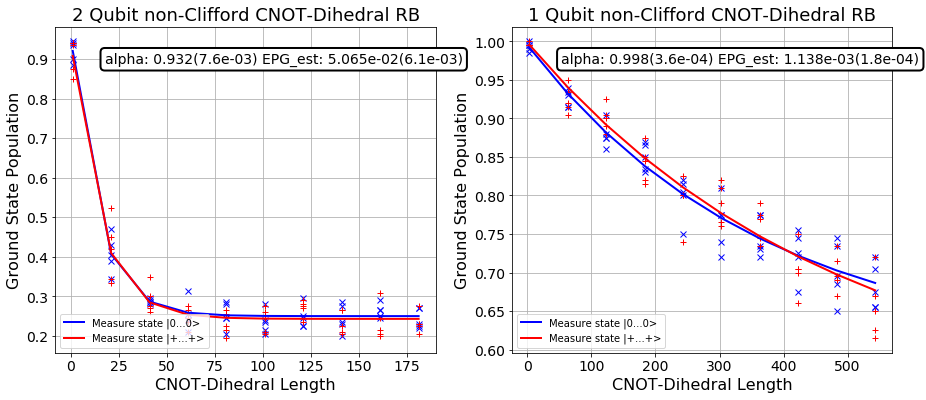

In [27]:
#Plot the joint RB data
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    joint_rb_fit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit non-Clifford CNOT-Dihedral RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

### Predicted Gate Fidelity

From the known depolarizing errors on the simulation we can predict the **fidelity**. First we need to count the number of gates per a CNOT-dihedral.

The function **gates_per_clifford** takes a compiled qobj and outputs the number of basis gates in each circuit.

(Naturally, in the CNOT-dihedral group there are no u2 gates, and unitary is the cs gate)

In [31]:
#Count the number of single and 2Q gates in the 2Q CNOT-dihedral group elemnets
print ("basis_gates:", basis_gates)
gates_per_elmnt = rb.rb_utils.gates_per_clifford(cnotdihedral_Z_qobj_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
for i in range(len(basis_gates)):
    print("Number of %s gates per CNOT-dihedral element: %f"%(basis_gates[i],
                                                              np.mean([gates_per_elmnt[0][i],gates_per_elmnt[1][i]])))

basis_gates: ['cx', 'id', 'u2', 'u3', 'unitary']
Number of cx gates per CNOT-dihedral element: 1.405217
Number of id gates per CNOT-dihedral element: 0.000000
Number of u2 gates per CNOT-dihedral element: 0.000000
Number of u3 gates per CNOT-dihedral element: 0.525761
Number of unitary gates per CNOT-dihedral element: 0.293261


The **twoQ_clifford_error** gives measured errors in the basis gates that were used to construct the CNOT-dihedral element. It assumes that the error in the underlying gates is depolarizing. It outputs the error per a 2-qubit CNOT-dihedral element.

The input to this function is:

- **ngates:** list of the number of gates per 2Q Clifford
- **gate_qubit:** list of the qubit corresponding to the gate (0, 1 or -1). -1 corresponds to the 2Q gate.
- **gate_err:** list of the gate errors

In [30]:
#Prepare lists of the number of qubits and the errors
ngates = np.zeros(8)
ngates[0:3] = gates_per_elmnt[0][0:3]
ngates[3:6] = gates_per_elmnt[1][0:3]
ngates[6] = gates_per_elmnt[0][3]
ngates[7] = gates_per_elmnt[0][4]
gate_qubits = np.array([0,0,0,1,1,1,-1,-1], dtype=int)
gate_errs = np.zeros(len(gate_qubits))
gate_errs[[1,4]] = p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[[2,5]] = 2*p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[6] = p2Q*3/4 #convert from depolarizing error to epg (2Q)
gate_errs[7] = p2Q*3/4/2 #convert from depolarizing error to epg (2Q)

#Calculate the predicted EPG
pred_epg = rb.rb_utils.twoQ_clifford_error(ngates,gate_qubits,gate_errs)
print("Predicted 2Q Error per a CNOT-dihedral element: %e"%pred_epg)

Predicted 2Q Error per a CNOT-dihedral element: 2.139737e-02
